Going for file 100
Going for file 200
Going for file 300
Going for file 400
Going for file 500
Going for file 600
Going for file 700
Nan values per column:   
 LINENAME         0
LINEWAVE         0
LINEZ            0
LINEZ_ERR        1
LINESIGMA        0
LINESIGMA_ERR    0
Z                0
file_name        0
dtype: int64
           LINENAME     LINEWAVE     LINEZ  LINEZ_ERR    LINESIGMA  \
4    b'C_III] 1908'  1908.734000  0.000000  -1.000000     0.000000   
2      b'C_IV 1549'  1549.480000  0.000000  -1.000000     0.000000   
27       b'H_alpha'  6564.613974  0.000421   0.000025    91.300972   
16        b'H_beta'  4862.683021  0.000421   0.000025    91.300972   
12       b'H_delta'  4102.891635  0.000421   0.000025    91.300972   
..              ...          ...       ...        ...          ...   
23    b'[O_I] 6300'  6302.046448 -0.001670   0.003476  7257.452637   
25    b'[O_I] 6363'  6365.535493 -0.001671   0.003476  7257.452637   
24  b'[S_III] 6312'  6313.805605 -0.001672   

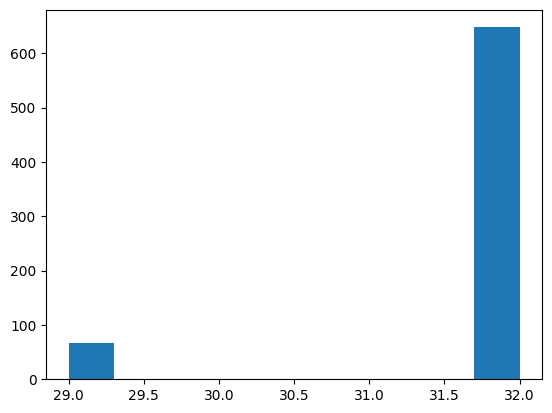

In [1]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)
import pandas as pd
from astropy.table import Table 
from astropy.io import fits
import matplotlib.pyplot as plt 
import torch
import SplinesNLines


all_data = pd.read_csv('Selection2_les_astro_guapes.csv') #Reads record data. 
all_data = all_data.drop_duplicates(subset= ['sdss_id'])
file_names = all_data['sas_file'].to_list() #Places all file names in a list. 
f1 = file_names[0]

"""
Note: Line profile information is read first to see which line profile information is available and how it varies. 
"""
#Read information for line profiles-----------------------------------------------------------------------------------------------------------
cols = ['LINENAME', 'LINEWAVE', 'LINEZ', 'LINEZ_ERR', 'LINESIGMA', 'LINESIGMA_ERR' ]

f1 = file_names[0]
table_line = Table.read(f1, hdu = 4)
table_line = table_line.to_pandas()
table_line = table_line[cols]
curr_file_z = Table.read(f1, format = 'fits', hdu = 2) #Reads file with z
curr_z = curr_file_z[0]['Z'] #Obtaines redshift. 

table_line['Z'] = curr_z
table_line['file_name'] = f1

no_prof = [] #Array to store the number of profiles in each file. 

var = [] #Adds to array the names of the profiles of those files with 29 recorded profiles. 
max_lam =[] #Array to store the maximum recorded value of wavelength. 
min_lam = []  #Array to store the minimum recorded value of wavelength. 
var_pos = []

"""
Index(['PLATE', 'MJD', 'FIBERID', 'LINENAME', 'LINEWAVE', 'LINEZ', 'LINEZ_ERR',
       'LINESIGMA', 'LINESIGMA_ERR', 'LINEAREA', 'LINEAREA_ERR', 'LINEEW',
       'LINEEW_ERR', 'LINECONTLEVEL', 'LINECONTLEVEL_ERR', 'LINENPIXLEFT',
       'LINENPIXRIGHT', 'LINEDOF', 'LINECHI2'],
      dtype='object')
Index(['PLATE', 'MJD', 'FIBERID', 'LINENAME', 'LINEWAVE', 'LINEZ', 'LINEZ_ERR',
       'LINESIGMA', 'LINESIGMA_ERR', 'LINEAREA', 'LINEAREA_ERR', 'LINEEW',
       'LINEEW_ERR', 'LINECONTLEVEL', 'LINECONTLEVEL_ERR', 'LINENPIXLEFT',
       'LINENPIXRIGHT', 'LINEDOF', 'LINECHI2'],
      dtype='object')

"""

for i in range(1, len(file_names)):
    if i%100 == 0:
        print(f"Going for file {i}")

    oth_table = Table.read(file_names[i], hdu = 1).to_pandas()
    curr_file_z = Table.read(file_names[i], format = 'fits', hdu = 2) #Reads file with z
    curr_z = curr_file_z[0]['Z'] #Obtaines redshift. 
    try:
        curr_table = Table.read(file_names[i], hdu = 4).to_pandas()
        curr_table = curr_table[cols]
        log_lam_curr = 10**oth_table['LOGLAM']
    except:
        curr_table = Table.read(file_names[i], hdu = 3).to_pandas()
        curr_table = curr_table[cols]
        log_lam_curr = 10**oth_table['loglam']

    max_lam.append(log_lam_curr.max()/(1+curr_z)  )
    min_lam.append(log_lam_curr.min()/(1+curr_z)   )
    curr_table['Z'] = curr_z
         
    curr_table['file_name'] = len(curr_table)*[file_names[i]]
    if len(curr_table) == 29:
        var.append(curr_table['LINENAME'].to_list())
        var_pos.append(curr_table['LINEWAVE'].to_list())
    no_prof.append(len(curr_table))
    table_line = pd.concat([table_line, curr_table])

print("Nan values per column:   \n",   table_line.isnull().sum())
line_sd_mean = table_line.groupby('LINENAME')['LINESIGMA'].mean()

table_line = table_line.sort_values(['file_name','LINENAME'])
to_use_profiles = var[0]
print(table_line)

to_use_profiles = list(dict.fromkeys([(x.decode('utf-8').strip()).replace(' ', '') 
                                      if isinstance(x, bytes) else (x.strip()).replace(' ', '') for x in to_use_profiles
                                    ])) #Convert to_use_profiles elements to strings and remove spaces. 
table_line['LINENAME'] = table_line['LINENAME'].str.decode('utf-8') #Change the format from bytes to string. 
table_line['LINENAME'] = table_line['LINENAME'].str.replace(' ', '') #Replace all of spaces with empty strings. 


table_line = table_line[ (table_line['LINESIGMA'] > 0) & (table_line['LINENAME'].isin(to_use_profiles)) ] #Select only those with LINESIGMA> 0 and that 
                                                                                                          #correspond to LINENAME's that are going to be used. 

print(table_line.columns)
plt.hist(no_prof)
plt.show()
#-----------------------------------------------------------------------------------------------------------------------------------------------





In [2]:
import numpy as np 


unique_pairs = (table_line[['LINENAME', 'LINEWAVE']].drop_duplicates().groupby('LINENAME', as_index=False).agg(LINEWAVE=('LINEWAVE', 'mean')))
line_sig_mean = (table_line.groupby('LINENAME', as_index= False).agg(LINESIGMA = ('LINESIGMA', 'mean'))  )
line_df = unique_pairs.merge(line_sig_mean, on = 'LINENAME')

line_wave = np.sort(line_df['LINEWAVE'].to_numpy())


all_line_data = {
    'LINEWAVE': [1215.67, 1240.81, 1549.48, 1640.42, 1908.734, 2800.3152, 3727.0917, 
                 3729.8754, 3869.8568, 3890.1511, 3971.1232, 4102.8916, 4341.6843, 
                 4364.4353, 4686.9915, 4862.6830, 4960.2949, 5008.2397, 5413.0245, 
                 5578.8878, 5756.1862, 5877.3086, 6302.0464, 6363.776, 6313.8056, 
                 6365.5355, 6549.8590, 6564.6140, 6585.2685, 6718.2943, 6732.6782, 
                 7137.7572],
    'LINENAME': ['Ly_alpha', 'N_V 1240', 'C_IV 1549', 'He_II 1640', 'C_III] 1908', 
                 'Mg_II 2799', '[O_II] 3725', '[O_II] 3727', '[Ne_III] 3868', 
                 'H_epsilon', '[Ne_III] 3970', 'H_delta', 'H_gamma', '[O_III] 4363', 
                 'He_II 4685', 'H_beta', '[O_III] 4959', '[O_III] 5007', 'He_II 5411', 
                 '[O_I] 5577', '[N_II] 5755', 'He_I 5876', '[O_I] 6300', '[O_I] 6363', 
                 '[S_III] 6312', '[O_I] 6363', '[N_II] 6548', 'H_alpha', '[N_II] 6583', 
                 '[S_II] 6716', '[S_II] 6730', '[Ar_III] 7135'],
    'ZINDEX': ['z_lya', 'zemission', 'zemission', 'zemission', 'zemission', 'zemission', 
               'zemission', 'zemission', 'zemission', 'zemission', 'zemission', 
               'zemission', 'zemission', 'zemission', 'zemission', 'zemission', 
               'zemission', 'zemission', 'zemission', 'zemission', 'zemission', 
               'zemission', 'zemission', 'zemission', 'zemission', 'zemission', 
               'zemission', 'zemission', 'zemission', 'zemission', 'zemission', 
               'zemission'],
    'WINDEX': ['w_ly_a', 'w_n_v', 'wemission', 'wemission', 'wemission', 'wemission', 
               'wemission', 'wemission', 'wemission', 'w_balmer', 'wemission', 
               'w_balmer', 'wemission', 'wemission', 'wemission', 'w_balmer', 
               'wemission', 'wemission', 'wemission', 'wemission', 'wemission', 
               'wemission', 'wemission', 'wemission', 'wemission', 'wemission', 
               'wemission', 'w_balmer', 'wemission', 'wemission', 'wemission', 
               'wemission']
}

all_line_data = pd.DataFrame(all_line_data)
line_data_use = all_line_data[(all_line_data['LINEWAVE'] > np.min(min_lam)) & (all_line_data['LINEWAVE'] < np.max(max_lam))]



In [3]:
B_f = 80 #Sets number of B-Spline functions to use. 
m = 2 #Value such that m+1 is the degree of the basis B-Spline functions. Needs: B_f + m + 2 knots. 
T = np.sort( np.concatenate([line_data_use['LINEWAVE'].to_numpy(), np.linspace(np.min(min_lam), np.max(max_lam), B_f + m + 2 - len(line_data_use['LINEWAVE'].to_numpy())   )  ]    ))
T = np.linspace(np.min(min_lam), np.max(max_lam), B_f + m + 2 )   


to_use_profiles_set = set(to_use_profiles)
thet_o = [] #np.zeros(  shape = ( len(file_names), B_f + len(line_wave)   ) )


not_used = []
p_inv_used = []
used = []

for o in range(len(file_names)):
    if o%100 == 0:
        print(f"Going for file {o}")

    f = file_names[o]
    curr_file = Table.read(f, hdu = 1).to_pandas() #Reads the .fits file corresponding to the Flux-wavelength data for f. 

    #For the current file, select those points without specified problems and with a stricty possitive precision parameter (IVAR).
    #The try-except helps to handle both .fits files from DR17 and DR19 without breaking the flow of execution. 
    try:
        curr_file = curr_file[(curr_file['AND_MASK'] == 0) & (curr_file['IVAR'] > 0)]
        tau_ok_name = 'IVAR'
        log_lam_name = 'LOGLAM'
        flux_name = 'FLUX'
        #curr_file_line = Table.read(f, hdu = 4).to_pandas()

    except:
        curr_file = curr_file[(curr_file['and_mask'] == 0) & (curr_file['ivar'] > 0)]
        tau_ok_name = 'ivar'
        log_lam_name = 'loglam'
        flux_name = 'flux'
        #curr_file_line = Table.open(f, hdu = 3).to_pandas()
        



    try:
        select_idx = [( (i+1)%np.ceil( len(curr_file)/1000) == 0  ) for i in range(len(curr_file)) ] #Reduces the number of points to use. 

        aux = table_line[table_line['file_name'] == f]
        curr_z = aux['Z'].iloc[0]
        curr_file = curr_file[select_idx] #Selects the points to use. 
        line_prof_curr = table_line[table_line['file_name'] == f]#Selects the line profile information for f. 
        line_prof_curr = line_prof_curr[['LINENAME', 'LINEWAVE', 'LINESIGMA']] 

        missing_line_prof =  list(to_use_profiles_set - set(line_prof_curr['LINENAME'].to_list())) #Checks which line profiles are missing. 
        if len(missing_line_prof) > 0:
            line_prof_curr = pd.concat([line_prof_curr, line_df[line_df['LINENAME'].isin(missing_line_prof)]])

        line_prof_curr = line_prof_curr.sort_values('LINEWAVE')        
        Tau_ok = curr_file[tau_ok_name].to_numpy()
        #To = curr_file[log_lam_name].to_numpy()
        To = (10**curr_file[log_lam_name].to_numpy())/(1+ curr_z) 

        X_B = SplinesNLines.get_basis_mat_B_Spline_opt(np.log10(To), B_f, m, T)
        X_L = SplinesNLines.eval_Line_Profiles_opt(To, line_wave, line_prof_curr['LINESIGMA'].to_numpy() ) #Falta width values
        fo = (curr_file[flux_name].to_numpy()).reshape(-1,1)
        X = np.hstack((X_B, X_L))

        try: 

            tht = (np.linalg.inv(X.T@np.diag(curr_file[tau_ok_name].to_numpy())@X)@X.T@np.diag(curr_file[tau_ok_name].to_numpy())@fo).flatten()

            if np.sum(np.isnan(tht)) > 0 or np.sum(np.isnan(pred)) > 0: 
                print(f"Error on file {f}. \n Found NaN's on estimation  \n Moving on...")
                not_used.append(f)
                print(f"Design matrix rank: {np.linalg.matrix_rank(X)}")
                print(f"Max observed value:  {np.max(fo)}")
                print(f"Min observed value: {np.min(fo)}")


            else:
                thet_o.append( tht)
                p_inv_used.append(0)

            
        except: 
            tht = (np.linalg.pinv(X.T@np.diag(curr_file[tau_ok_name].to_numpy())@X)@X.T@np.diag(curr_file[tau_ok_name].to_numpy())@fo).flatten()

            if np.sum(np.isnan(tht)) > 0: 
                print(f"Error on file {f}. \n Found NaN's on estimation  \n Moving on...")
                not_used.append(f)
                print(f"Design matrix rank: {np.linalg.matrix_rank(X)}")
                print(f"Max observed value:  {np.max(fo)}")
                print(f"Min observed value: {np.min(fo)}")


            else:

                thet_o.append( tht)
                p_inv_used.append(0)
        used.append(f)


    except:
        print(f"Error on file {f}. \n Moving on...")
        not_used.append(f)




Going for file 0
Going for file 100
Going for file 200
Going for file 300
Going for file 400
Going for file 500
Going for file 600
Error on file spec-7881-57282-0453.fits. 
 Moving on...
Going for file 700


[0.42496182 0.54831987 0.62570886 0.68867247 0.73416478 0.76848159
 0.79944918 0.82515005 0.84546215 0.86444485 0.88269516 0.8978625
 0.91235379 0.92365539 0.93475761 0.94485884 0.95360069 0.96153068
 0.96849887 0.97514953 0.98080888 0.98580283 0.9899249  0.99321669
 0.99557808 0.99730263 0.99849859 0.99933496 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.

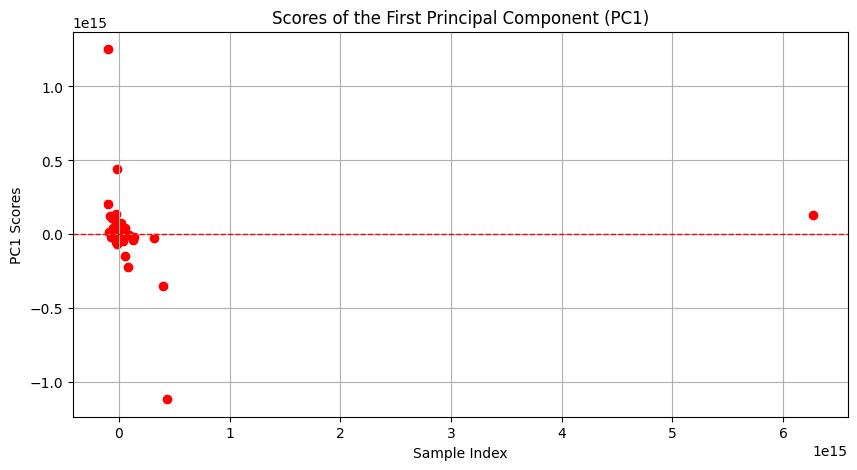

In [4]:
from sklearn.decomposition import PCA
import scipy.stats as sts
pca = PCA()
thet_o = np.array(thet_o)

pca.fit(thet_o)
pve = np.cumsum( np.array(pca.singular_values_))/np.sum(np.array(pca.singular_values_))
components = pca.components_ 


print(pve)
scores = pca.fit_transform(thet_o)  # Get all component scores
pc1_scores = scores[:, 0]  # First column

pc2_scores = scores[:, 1]


S = pca.get_covariance()
Si = np.linalg.inv(S)
mu = pca.mean_.reshape(-1,1)
print(S.shape)
print(mu.shape)

plt.figure(figsize=(10, 5))
p_inv_used = np.array(p_inv_used).astype(bool)
print(np.sum(p_inv_used))
plt.scatter( pc1_scores[p_inv_used], pc2_scores[p_inv_used])
plt.scatter( pc1_scores[p_inv_used == False], pc2_scores[p_inv_used == False], color = 'red')

plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  # Reference line at 0
plt.xlabel('Sample Index')
plt.ylabel('PC1 Scores')
plt.title('Scores of the First Principal Component (PC1)')
plt.grid(True)
plt.show()


In [ ]:
B_f = 80 #Sets number of B-Spline functions to use. 
m = 2 #Value such that m+1 is the degree of the basis B-Spline functions. Needs: B_f + m + 2 knots. 
T = np.sort( np.concatenate([line_data_use['LINEWAVE'].to_numpy(), np.linspace(np.min(min_lam), np.max(max_lam), B_f + m + 2 - len(line_data_use['LINEWAVE'].to_numpy())   )  ]    ))
T = np.linspace(np.min(min_lam), np.max(max_lam), B_f + m + 2 )   


to_use_profiles_set = set(to_use_profiles)
thet_o = [] #np.zeros(  shape = ( len(file_names), B_f + len(line_wave)   ) )


zeros = np.zeros(B_f + len(line_wave))
not_used = []
p_inv_used = []
used = []

for o in range(len(file_names)):
    if o%100 == 0:
        print(f"Going for file {o}")

    f = file_names[o]
    curr_file = Table.read(f, hdu = 1).to_pandas() #Reads the .fits file corresponding to the Flux-wavelength data for f. 

    #For the current file, select those points without specified problems and with a stricty possitive precision parameter (IVAR).
    #The try-except helps to handle both .fits files from DR17 and DR19 without breaking the flow of execution. 
    try:
        curr_file = curr_file[(curr_file['AND_MASK'] == 0) & (curr_file['IVAR'] > 0)]
        tau_ok_name = 'IVAR'
        log_lam_name = 'LOGLAM'
        flux_name = 'FLUX'
        #curr_file_line = Table.read(f, hdu = 4).to_pandas()

    except:
        curr_file = curr_file[(curr_file['and_mask'] == 0) & (curr_file['ivar'] > 0)]
        tau_ok_name = 'ivar'
        log_lam_name = 'loglam'
        flux_name = 'flux'
        #curr_file_line = Table.open(f, hdu = 3).to_pandas()




    try:
        select_idx = [( (i+1)%np.ceil( len(curr_file)/1000) == 0  ) for i in range(len(curr_file)) ] #Reduces the number of points to use. 

        aux = table_line[table_line['file_name'] == f]
        curr_z = aux['Z'].iloc[0]
        curr_file = curr_file[select_idx] #Selects the points to use. 
        line_prof_curr = table_line[table_line['file_name'] == f]#Selects the line profile information for f. 
        line_prof_curr = line_prof_curr[['LINENAME', 'LINEWAVE', 'LINESIGMA']] 

        missing_line_prof =  list(to_use_profiles_set - set(line_prof_curr['LINENAME'].to_list())) #Checks which line profiles are missing. 
        if len(missing_line_prof) > 0:
            line_prof_curr = pd.concat([line_prof_curr, line_df[line_df['LINENAME'].isin(missing_line_prof)]])

        line_prof_curr = line_prof_curr.sort_values('LINEWAVE')        
        Tau_ok = curr_file[tau_ok_name].to_numpy()
        #To = curr_file[log_lam_name].to_numpy()
        To = (10**curr_file[log_lam_name].to_numpy())/(1+ curr_z) 

        X_B = SplinesNLines.get_basis_mat_B_Spline_opt(np.log10(To), B_f, m, T)
        X_L = SplinesNLines.eval_Line_Profiles_opt(To, line_wave, line_prof_curr['LINESIGMA'].to_numpy() ) #Falta width values
        fo = (curr_file[flux_name].to_numpy()).reshape(-1,1)
        X = np.hstack((X_B, X_L))

        try: 
            T_d = np.diag(curr_file[tau_ok_name].to_numpy()   ) 
            tht = (np.linalg.inv(Si + X.T@T_d@X)@(X.T@T_d@fo  + Si@mu )).flatten()
            pred = X@tht

            if np.sum(np.isnan(tht)) > 0 or np.sum(np.isnan(pred)) > 0: 
                print(f"Error on file {f}. \n Found NaN's on estimation  \n Moving on...")
                not_used.append(f)
                print(f"Design matrix rank: {np.linalg.matrix_rank(X)}")
                print(f"Max observed value:  {np.max(fo)}")
                print(f"Min observed value: {np.min(fo)}")
                print(f" No of NaN in pred {np.sum(np.isnan(pred))} ")


            else:
                thet_o.append( tht)
                p_inv_used.append(0)

            
        except: 
            T_d = np.diag(curr_file[tau_ok_name].to_numpy()   ) 
            tht = (np.linalg.pinv(Si + X.T@T_d@X)@(X.T@T_d@fo  + Si@mu )).flatten()
            pred = X@tht

            if np.sum(np.isnan(tht)) > 0 or np.sum(np.isnan(pred)) > 0 : 
                print(f"Error on file {f}. \n Found NaN's on estimation  \n Moving on...")
                not_used.append(f)
                print(f"Design matrix rank: {np.linalg.matrix_rank(X)}")
                print(f"Max observed value:  {np.max(fo)}")
                print(f"Min observed value: {np.min(fo)}")
                print(f" No of NaN in pred {np.sum(np.isnan(pred))} ")


            else:

                thet_o.append( tht)
                p_inv_used.append(0)
        used.append(f)
        zeros += tht



        if np.sum(np.isnan(zeros)):
            print("Crashed!")



    except:
        print(f"Error on file {f}. \n Moving on...")
        not_used.append(f)
    




Going for file 0
Going for file 100
Going for file 200
Going for file 300
Going for file 400
Going for file 500
Going for file 600
Error on file spec-7881-57282-0453.fits. 
 Moving on...
Going for file 700


In [55]:
L = len(to_use_profiles) #Sets number of line profiles. 
T = np.linspace(np.min(min_lam), np.max(max_lam), B_f + m + 2) #Sets equally spaced knots for B-Spline basis. 
                                                                 #Limits are based on the mean min_lam and max_lam values. 
to_use_profiles_set = set(to_use_profiles)
X_a = []
f_a = []
T_a = []
max_vals = []
not_used = []

for o in range(len(file_names)):
    if o%100 == 0:
        print(f"Going for file {o}")

    f = file_names[o]
    curr_file = Table.read(f, hdu = 1).to_pandas() #Reads the .fits file corresponding to the Flux-wavelength data for f. 

    #For the current file, select those points without specified problems and with a stricty possitive precision parameter (IVAR).
    #The try-except helps to handle both .fits files from DR17 and DR19 without breaking the flow of execution. 
    try:
        curr_file = curr_file[(curr_file['AND_MASK'] == 0) & (curr_file['IVAR'] > 0)]
        tau_ok_name = 'IVAR'
        log_lam_name = 'LOGLAM'
        flux_name = 'FLUX'
        #curr_file_line = Table.read(f, hdu = 4).to_pandas()

    except:
        curr_file = curr_file[(curr_file['and_mask'] == 0) & (curr_file['ivar'] > 0)]
        tau_ok_name = 'ivar'
        log_lam_name = 'loglam'
        flux_name = 'flux'
        #curr_file_line = Table.open(f, hdu = 3).to_pandas()


    try:


        select_idx = [( (i+1)%np.ceil( len(curr_file)/1000) == 0  ) for i in range(len(curr_file)) ] #Reduces the number of points to use. 

        aux = table_line[table_line['file_name'] == f]
        curr_z = aux['Z'].iloc[0]
        curr_file = curr_file[select_idx] #Selects the points to use. 
        line_prof_curr = table_line[table_line['file_name'] == f]#Selects the line profile information for f. 
        line_prof_curr = line_prof_curr[['LINENAME', 'LINEWAVE', 'LINESIGMA']] 

        missing_line_prof =  list(to_use_profiles_set - set(line_prof_curr['LINENAME'].to_list())) #Checks which line profiles are missing. 
        if len(missing_line_prof) > 0:
            line_prof_curr = pd.concat([line_prof_curr, line_df[line_df['LINENAME'].isin(missing_line_prof)]])

        line_prof_curr = line_prof_curr.sort_values('LINEWAVE')        
        Tau_ok = curr_file[tau_ok_name].to_numpy()
        #To = curr_file[log_lam_name].to_numpy()
        To = (10**curr_file[log_lam_name].to_numpy())/(1+ curr_z) 

        X_B = SplinesNLines.get_basis_mat_B_Spline_opt(np.log10(To), B_f, m, T)
        X_L = SplinesNLines.eval_Line_Profiles_opt(To, line_wave, line_prof_curr['LINESIGMA'].to_numpy() ) #Falta width values
        fo = (curr_file[flux_name].to_numpy()).reshape(-1,1)
        X = np.hstack((X_B, X_L))

        #X_L = SplinesNLines.eval_Line_Profiles_opt(To, line_wave, line_prof_curr['LINESIGMA'].to_numpy() ) #Falta width values
        fo = (curr_file[flux_name].to_numpy()).reshape(-1,1)
        X_a.append(X)
        #X_a.append(np.hstack((X_B, X_L)))
        T_a.append(np.diag(curr_file[tau_ok_name].to_numpy()))
        f_a.append(fo)
        max_vals.append(np.max(fo))
    except:
        print(f"Error on file {f}. \n Moving on...")
        not_used.append(f)

Going for file 0
Going for file 100
Going for file 200
Going for file 300
Going for file 400
Going for file 500
Going for file 600
Error on file spec-7881-57282-0453.fits. 
 Moving on...
Going for file 700


In [56]:
f_a = [ f/np.max(max_vals) for f in f_a]

A = SplinesNLines.get_mat_comp(X_a, f_a, T_a)



In [ ]:
from torch import linalg as LA

def EM_alg(XtXf, XtTX, n_max, tol):
    B = XtTX.shape[1]
    O = XtXf.shape[0]

    #if S0 == None: 
    L = np.random.normal(size = B).reshape(-1,1)
    S =  torch.from_numpy(10*L@L.T + np.eye(B) ) #Gets first estimate for S
    #if mu0 == None: 
    mu = torch.from_numpy(np.random.uniform(10, 100, size = B).reshape(-1,1) )#Gets first estimate for mu. 


        
    m0 = torch.zeros(O, B)
    XtTX = torch.from_numpy(XtTX).double() #Converts XtTX to a torch tensor. 
    XtXf = torch.from_numpy(XtXf).double()
    m0_outer = torch.zeros(O, B, B) #Creates a torch tensor to store outer products of m0's. 

    i = 0 
    diff_S = tol + np.pi 
    diff_mu = tol + np.pi
    while (i <n_max ) and ( (diff_S**2/B**2 > tol) or (diff_mu > tol) ):
        if i % 1000 == 0:
            print("Iteration:  ", i)



        print("---------------------------------------------------------------------------------------------")

        Si = LA.inv(S) #Calculates inverse of current iteration for variance covariance. 

        print("S max ",  torch.max(S))
        print("Si max    ",torch.max(Si),  "No nan   ", torch.sum(torch.isnan(Si)),   " no inf   ", torch.sum(torch.isinf(Si)), " S rank   ", LA.matrix_rank(S))
        C0 = LA.inv(Si + XtTX) #Calculates C0's = inv(Si + XtXT), I hope (O, B, B)
        print("C0 max,  ", torch.max(C0),  "No nan   ", torch.sum(torch.isnan(C0)),   " no inf   ", torch.sum(torch.isinf(C0)))

        print("mu max ", torch.max(mu),     " mu0 max    ", torch.max(mu0))
        f = (Si.double()@mu.double()).squeeze(-1)

        print("No NaN  f ", torch.sum(torch.isnan(f)),   "No inf  f ", torch.sum(torch.isinf(f)))

        print("f max   ",torch.max(f))
        m0 = torch.bmm(C0, (XtXf + f).unsqueeze(-1)).squeeze(-1).double()


        print("m0,  ", torch.max(m0))
        print("No NaN  m0 ", torch.sum(torch.isnan(m0)),   "No inf  m0 ", torch.sum(torch.isinf(m0)))

        
        m0_outer = torch.bmm(m0.unsqueeze(-1), m0.unsqueeze(-2))

        print("m0 outer  ",torch.max(m0_outer),  "No NaN  m0_outer ", torch.sum(torch.isnan(m0_outer)),   "No inf  m0_outer ", torch.sum(torch.isinf(m0_outer)), "shape m0  ,",m0_outer.shape)

        mu_n = torch.mean(m0, 0).reshape(-1,1) #Gets new mean estimate. 
        S_n = torch.mean(C0 + m0_outer, axis = 0) - mu_n@mu_n.T #Gets new iteration for S_n
        diff_S = LA.matrix_norm(S_n - S) #Computes matrix norm of current iteration and previous one. 
        diff_mu = LA.matrix_norm(mu_n - mu) #Computes matrix norm of current iteration and previous one. 
        mu = mu_n
        S = S_n 
        i+= 1
        print("---------------------------------------------------------------------------------------------")


    return {'mu_h':mu_n, 'S_h':S_n, 'm0':m0, 'Si_h':Si}


In [57]:
L = SplinesNLines.EM_alg(A['XtXf'], A['XtTX'], n_max = 10000, tol = 1e-10)

Iteration:   0
Iteration:   1000
Iteration:   2000
Iteration:   3000
Iteration:   4000
Iteration:   5000
Iteration:   6000
Iteration:   7000
Iteration:   8000
Iteration:   9000


C:\Users\End User\AppData\Local\Temp\ipykernel_23460\482264148.py:5: RuntimeWarning: overflow encountered in power
  T_mu_10 = 10**T_mu


tensor([[33.2296],
        [34.0274],
        [34.8345],
        [35.6462],
        [36.4580],
        [37.2651],
        [38.0631],
        [38.8473],
        [39.6142],
        [40.3644],
        [41.0996],
        [41.8211],
        [42.5304],
        [43.2291],
        [43.9186],
        [44.6003],
        [45.2759],
        [45.9467],
        [46.6143],
        [47.2802],
        [47.9457],
        [48.6125],
        [49.2820],
        [49.9557],
        [50.6351],
        [51.3217],
        [52.0169],
        [52.7222],
        [53.4392],
        [54.1693],
        [54.9140],
        [55.6748],
        [56.4532],
        [57.2507],
        [58.0687],
        [58.9087],
        [59.7721],
        [60.6569],
        [61.5579],
        [62.4702],
        [63.3885],
        [64.3077],
        [65.2226],
        [66.1281],
        [67.0191],
        [67.8904],
        [68.7368],
        [69.5532],
        [70.3345],
        [71.0755],
        [71.7711],
        [72.4161],
        [73.

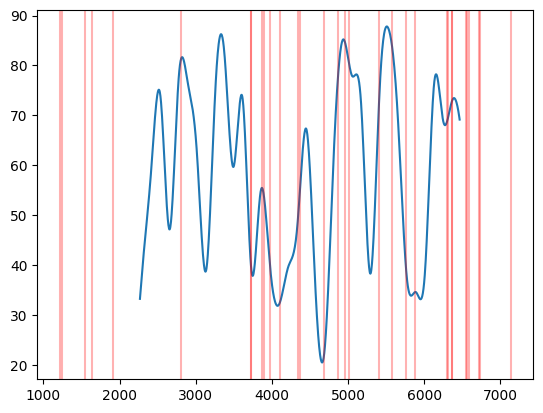

tensor([[ 2.8710e+10],
        [ 2.8551e+10],
        [ 3.6020e+09],
        [ 5.3498e+09],
        [ 2.6681e+10],
        [ 2.3426e+10],
        [ 2.3784e+10],
        [ 2.6567e+10],
        [ 2.2379e+10],
        [ 2.5154e+10],
        [ 1.9673e+10],
        [ 2.4430e+10],
        [ 3.8511e+09],
        [ 1.3553e+10],
        [ 1.8397e+10],
        [ 2.9710e+10],
        [ 8.2986e+09],
        [ 2.9958e+10],
        [ 2.4430e+10],
        [ 2.3029e+10],
        [ 6.5262e+09],
        [ 2.7475e+10],
        [ 3.0340e+10],
        [ 1.3974e+10],
        [ 3.1318e+10],
        [ 5.4456e+09],
        [ 2.2782e+10],
        [ 1.1631e+10],
        [ 9.4469e+09],
        [ 1.3847e+10],
        [ 1.3207e+10],
        [ 2.7450e+10],
        [ 9.3817e+09],
        [ 3.4942e+09],
        [ 2.2317e+10],
        [ 3.0459e+10],
        [ 2.3666e+10],
        [ 2.8391e+10],
        [ 4.7596e+09],
        [ 2.7979e+10],
        [ 2.9817e+10],
        [ 2.4790e+10],
        [ 9.0938e+09],
        [ 1

In [66]:
mu_h = L['mu_h']
S_h = L['S_h']

T_mu = np.linspace(np.mean(min_lam), np.mean(max_lam), num = 1000)
T_mu_10 = 10**T_mu
X_mu_B = SplinesNLines.get_basis_mat_B_Spline_opt(T_mu, B_f, m, T)
X_mu_L = SplinesNLines.eval_Line_Profiles_opt(T_mu_10,  line_wave, line_prof_curr['LINESIGMA'].to_numpy())
X_mu = np.hstack((X_mu_B, X_mu_L))
mu = torch.from_numpy(X_mu)@mu_h

line_waves = line_data_use['LINEWAVE'].to_numpy()
line_names = line_data_use['LINENAME'].to_list()

plt.plot( T_mu, mu  )

for i in range(len(line_waves)):
    lw = line_waves[i]
    idx_T = np.searchsorted(T_mu, lw)
    plt.axvline(x = lw, color = 'red', alpha = 0.3)

print(mu)
plt.show()
print(np.max(max_vals)*mu_h)

True
True
True
True
True
True
True
True
True
True
True
True


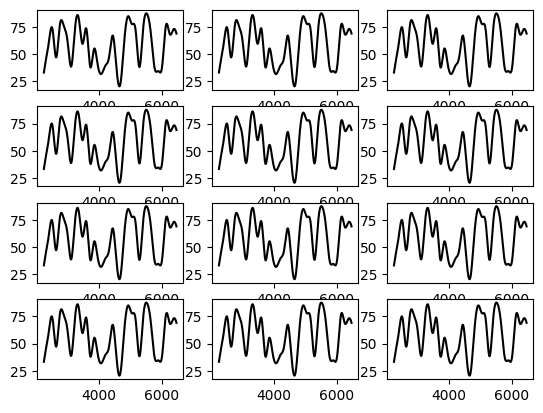

In [82]:
l = T_mu
X_g = torch.from_numpy(X_mu)

nr = 4
nc = 3
No = nr*nc
five_galaxies_m0 = L['m0'][0:No, :]
five_f = f_a[0:No]
five_To = T_a[0:No]

fig, ax = plt.subplots(nrows = nr,  ncols = nc)
ax = ax.flatten()
colors = plt.cm.tab10.colors[:No]  # First 'n' colors from 'tab10' colormap

for i in range(No):
    mu = X_g@five_galaxies_m0[i, :].T
    print(len(five_To[i])  == len(five_f[i]))
    x_vals = np.array(five_To[i]).ravel()
    y_vals = (np.max(max_vals)*np.array(five_f[i])).ravel()
    

    #ax[i].scatter(five_To[i].ravel(),    np.max(max_vals)*five_f[i].ravel(), alpha = 0.1 , color = 'grey') # color = colors[i])
    ax[i].plot(l, mu, color = 'black')


plt.show()